In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

Get filenames

In [2]:
base_path = "G:\\Data\\Projects\\NbSe2\\AC studies\\"
hechos_OOC_paths = glob.glob(base_path + "Set C\\*_OOC*_pulsed_measurement.dat")
hechos_IC_paths = glob.glob(base_path + "Set C\\*_IC*_pulsed_measurement.dat")

Analyse HEcho

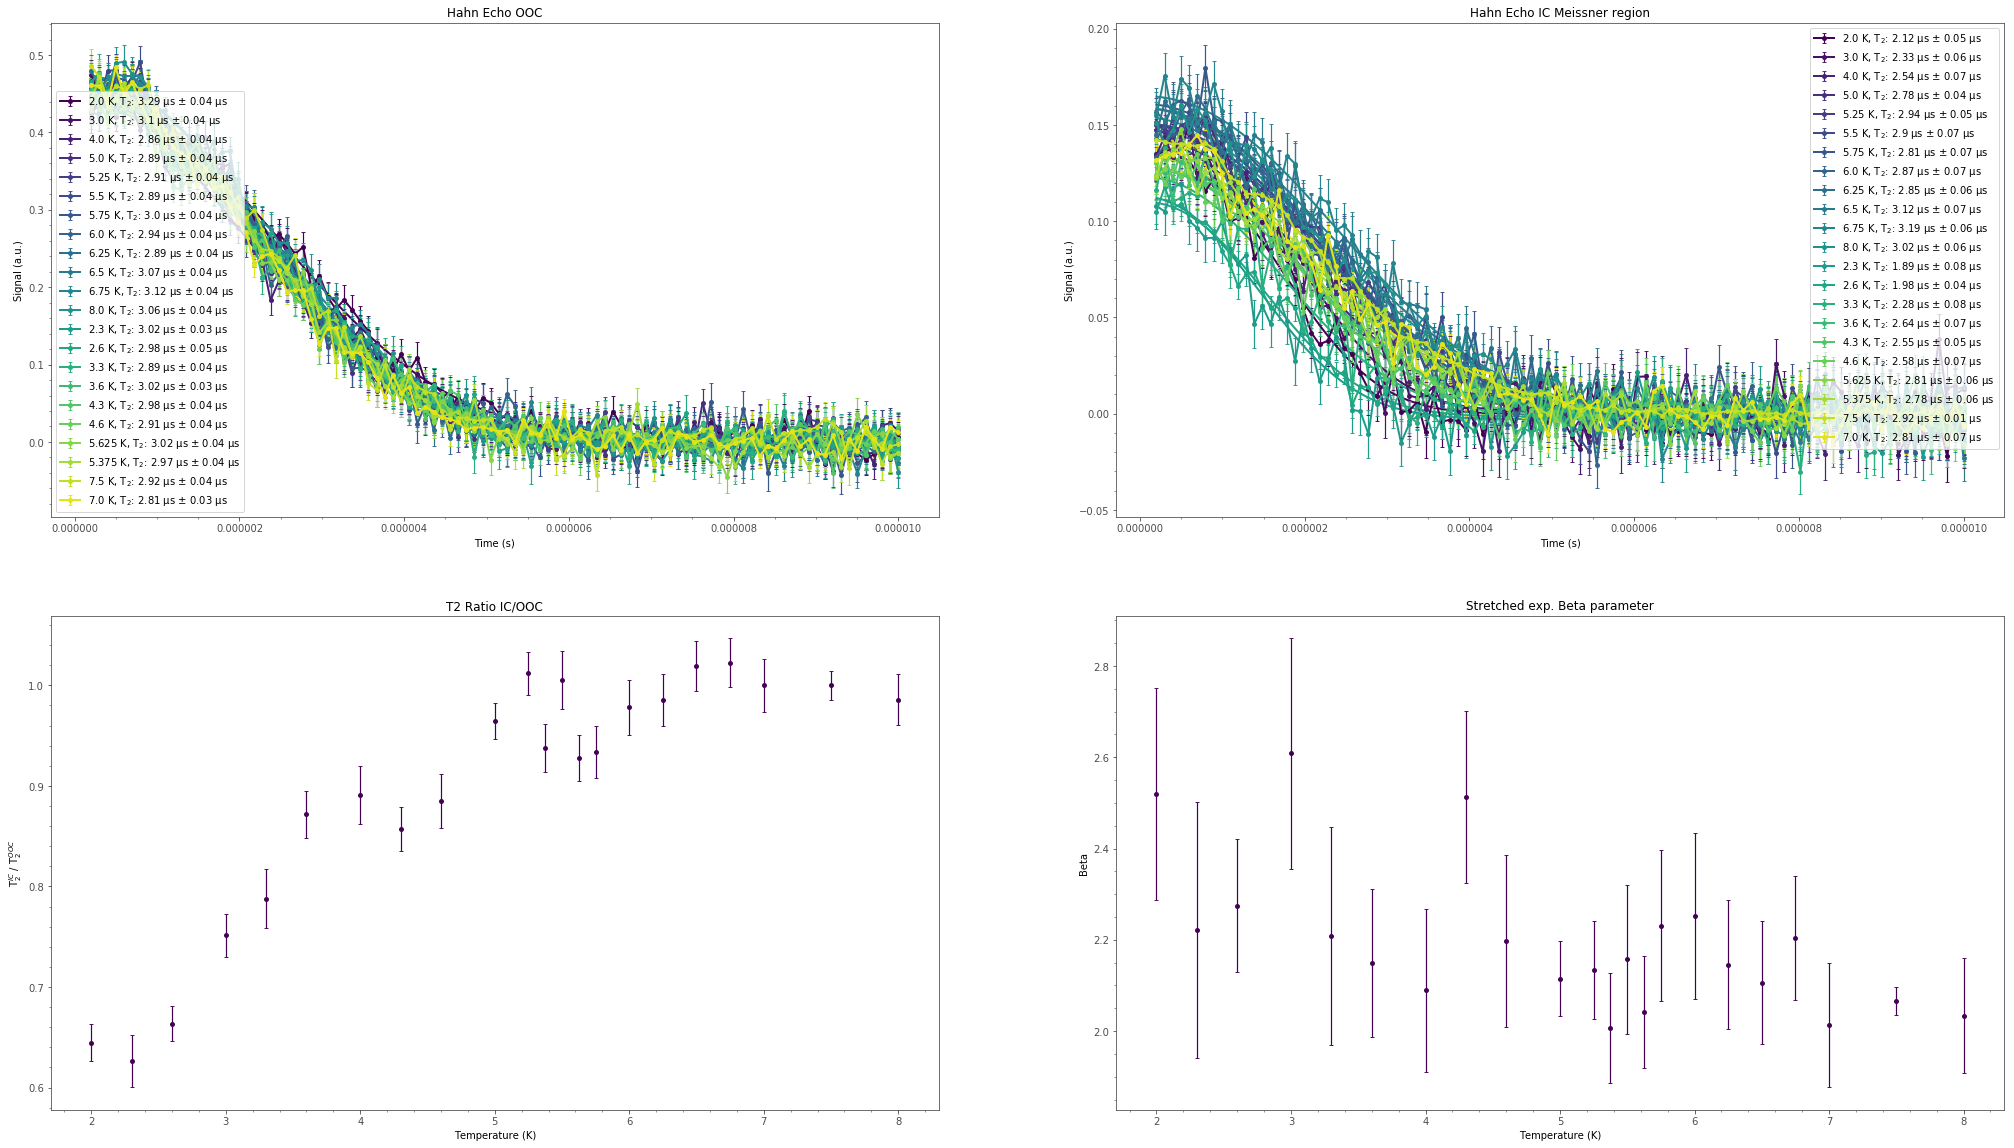

Using laser voltage:  0.0615 V
Using LO_freq:  2.54016 GHz
Using target_freq:  2.44016 GHz
Using power:  -1 dBm
invoke_settings:
  False
controlled_variable:
  [0.00000000e+00 4.08163265e-09 8.16326531e-09 1.22448980e-08
 1.63265306e-08 2.04081633e-08 2.44897959e-08 2.85714286e-08
 3.26530612e-08 3.67346939e-08 4.08163265e-08 4.48979592e-08
 4.89795918e-08 5.30612245e-08 5.71428571e-08 6.12244898e-08
 6.53061224e-08 6.93877551e-08 7.34693878e-08 7.75510204e-08
 8.16326531e-08 8.57142857e-08 8.97959184e-08 9.38775510e-08
 9.79591837e-08 1.02040816e-07 1.06122449e-07 1.10204082e-07
 1.14285714e-07 1.18367347e-07 1.22448980e-07 1.26530612e-07
 1.30612245e-07 1.34693878e-07 1.38775510e-07 1.42857143e-07
 1.46938776e-07 1.51020408e-07 1.55102041e-07 1.59183673e-07
 1.63265306e-07 1.67346939e-07 1.71428571e-07 1.75510204e-07
 1.79591837e-07 1.83673469e-07 1.87755102e-07 1.91836735e-07
 1.95918367e-07 2.00000000e-07]
number_of_lasers:
  50
laser_ignore_list:
  []
alternating:
  False
units:
 

Traceback (most recent call last):
  File "C:\Users\yy3\Documents\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-e17730d92865>", line 1, in <module>
    seq_part = {'channel_info' : [   {'name': 'a_ch0', 'amp': 2.0 if user_MW_true else 0.0, 'freq': delta, 'phase': init_phase[0]+phase},
NameError: name 'user_MW_true' is not defined


In [3]:
import matplotlib

temp = np.zeros(len(hechos_OOC_paths))
t2_OOC = np.zeros(len(hechos_OOC_paths))
t2_IC= np.zeros(len(hechos_IC_paths))
t2_OOC_err = np.zeros(len(hechos_OOC_paths))
t2_IC_err= np.zeros(len(hechos_IC_paths))
t2_IC_pow= np.zeros(len(hechos_IC_paths))
t2_IC_pow_err = np.zeros(len(hechos_IC_paths))

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(hechos_OOC_paths))

fig = plt.figure(figsize=(35,20))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
# ax1.set_xscale('log')
# ax2.set_xscale('log')

axes = [ax1,ax2]
t2s = [t2_OOC, t2_IC]
t2s_err = [t2_OOC_err, t2_IC_err]

for idx, l in enumerate([hechos_OOC_paths, hechos_IC_paths]):
    for path_idx, path in enumerate(l):

        rgba = cmap(norm(path_idx))
        data_raw = np.loadtxt(path).T

        tempstr = re.search(r'\d\d?\d?\.?\d?\d?\d?K', path)

        t = float(tempstr.group()[:-1])
        temp[path_idx] = t 

        var_list = data_raw[0]

        mode = 'exp_decay_stretched'
        plot_option = 3 #1 = Signal1, 2 = Signal2, 3 = delta of signals
        err = None

        #Choose what to plot
        if plot_option == 3:
            data = data_raw[1] - data_raw[2]
            shift = (data_raw.shape[0]-1)//2
            err1 = abs(data_raw[1+shift])
            err2 = abs(data_raw[2+shift])
            err = err1+err2
        else:
            data = data_raw[plot_option]
            shift = (data_raw.shape[0]-1)//2
            err = data_raw[plot_option+shift]

        if mode == 'exp_decay_stretched':
            fit = afm_scanner_logic._fitlogic.make_decayexponentialstretched_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_decayexponentialstretched)
            lm,_ = fitlogic.make_decayexponentialstretched_model()
            leg = f"T$_2$: {round(fit.params['lifetime']*1e6,2)} µs $\pm$ {round(fit.params['lifetime'].stderr*1e6,2)} µs"
            axes[idx].set_xlabel('Time (s)')
            axes[idx].set_ylabel('Signal (a.u.)')

        #Plot Data an
        t2s[idx][path_idx] = fit.params['lifetime']
        t2s_err[idx][path_idx] = fit.params['lifetime'].stderr
        if idx==1:
            t2_IC_pow[path_idx] = fit.params['beta']
            t2_IC_pow_err[path_idx] = fit.params['beta'].stderr

        if not err is None:
            axes[idx].errorbar(x=var_list, y=data,
                         yerr=err, fmt='-o',
                         capsize=2, capthick=0.9,
                        elinewidth=1.2, label=f'{temp[path_idx]} K, '+leg, color=rgba)
        else:
            axes[idx].plot(var_list,data,'bo', label=temp[path_idx], color=rgba)

        x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
        axes[idx].plot(x, lm.eval(fit.params, x=x),'k-', color=rgba)
        axes[idx].legend()


# ax3.plot(temp, t2_OOC,color=cmap(norm(0)),label='OOC')
# ax3.plot(temp, t2_IC,color=cmap(norm(4)),label='IC')
# ax3.plot(temp, t2_IC/t2_OOC,color=cmap(norm(0)))
err = np.sqrt((t2_IC_err/t2_OOC)**2+(t2_IC/t2_OOC**2*t2_OOC_err)**2)
ax3.errorbar(x=temp, y=t2_IC/t2_OOC,
                yerr=err, fmt='o',
                capsize=2, capthick=0.9,
                elinewidth=1.2, color=cmap(norm(0)))
ax4.errorbar(x=temp, y=t2_IC_pow,
                yerr=t2_IC_pow_err, fmt='o',
                capsize=2, capthick=0.9,
                elinewidth=1.2, color=cmap(norm(0)))


ax3.set_xlabel('Temperature (K)')
ax3.set_ylabel('T$_2^{IC}$ / T$_2^{OOC}$')


ax4.set_xlabel('Temperature (K)')
ax4.set_ylabel('Beta')

ax1.title.set_text('Hahn Echo OOC')
ax2.title.set_text('Hahn Echo IC Meissner region')
ax3.title.set_text('T2 Ratio IC/OOC')
ax4.title.set_text('Stretched exp. Beta parameter')
        
plt.rcParams['figure.figsize'] = (9, 6)
fontsize = 12
plt.show()


In [32]:
plt.style.use('default')
# plt.plot(temp, hecho_meas0)

color1 = (80/255,80/255,255/255)
color2 = (255/255,80/255,80/255)

plt.errorbar(x=temp, y=hecho_meas0,
                     yerr=hecho_meas0_err, fmt='-o', color=color1,
                     capsize=2, capthick=0.9,
                     elinewidth=1.2)

plt.xlabel('Temp. (K)')
plt.ylabel('T2 time ($\mu$s)')
plt.xlim(1.5,10)
plt.ylim(0.2,1.8)

with open(base_path+f'_jupyter_plot_setD1.svg', 'wb') as f:
    plt.savefig(f,format='svg',dpi=700)

plt.show()

In [26]:
print(temp)